In [2]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt 

## Preparing Pseudo-Data

Our end product takes in user-inputted datasets. For demonstration purposes, we created the following sample data: 
- A `nodes` dataframe consisted of 40 nodes, each with a randomly assigned *discrete* opinion;  
- An `edges` dataframe consisted of 100 edges, with randomly selected starting and ending nodes;
- A `nodes2` dataframe consisted of 40 nodes, each with a randomly assigned *continuous* opinion.

Running the following code will save the sample data to your local directory. If you would like to visualize different datasets, you just have to make sure that the column names are consistent with that in the sample data. 

In [3]:
np.random.seed(1234)
#generate 40 nodes, with randomly assigned discrete opinions 
nodes = pd.DataFrame({
    "ind": np.arange(0,40),
    "opinion": np.random.randint(0,2, size = 40)
})
nodes.head()

,ind,opinion
0,0,1
1,1,1
2,2,0
3,3,1
4,4,0


In [6]:
np.random.seed(1234)
#generate 100 edges, each with a random starting point and a random ending point 
edges = pd.DataFrame({
    "start": np.random.randint(0,40,size=100),
    "end": np.random.randint(0,40,size=100)
})

#for cases where the starting and ending nodes are the same, add 1 to the ending node 
edges['end'].loc[edges.start == edges.end] +=1

#creating a list of tuples containing starting and ending nodes
edges['tup'] = list(zip(edges['start'], edges['end']))

edges.head()

,start,end,tup
0,19,8,"(19, 8)"
1,38,2,"(38, 2)"
2,12,16,"(12, 16)"
3,24,2,"(24, 2)"
4,15,16,"(15, 16)"


In [5]:
import random 
random.seed(1234)

#generate 40 nodes, with randomly assigned continuous opinions 
nodes2 = pd.DataFrame({
    "ind": np.arange(0,40),
})

#assign a continuous opinion between 0 and 1 to each node 
nodes2['opinion'] = nodes2['ind'].apply(lambda x: round(random.uniform(0,1),2)) 
nodes2.head()

,ind,opinion
0,0,0.97
1,1,0.44
2,2,0.01
3,3,0.91
4,4,0.94


In [7]:
#export nodes and edges dataframes as csv files
#will be used as sample dataset 
nodes.to_csv('nodes.csv', index = False)
edges.to_csv('edges.csv', index = False)
nodes2.to_csv('nodes2.csv', index = False)

## Creating Network

First we need to write a `make_network` function that transforms the nodes and edges dataframes into an actual network. The resulting network should contain three node attributes:
- *opinion* = the opinion of the node, could either be discrete or continuous 
- *degree* = the degree of the node, which is defined as number of neighbors that the node has  
- *size* = directly proportional to the degree

and one edge attribute:
- *edge_color* = orange if the two nodes hold different opinions and black otherwise. 

To make it easier to access later, we'll write separate functions for setting the attributes.

In [8]:
def set_opinion_attrs(G, nodes):
    '''
    Sets the opinion attribute of a network G
    '''
    #creating attribute dictionary
    opinion_dict = {}
    for i in range(len(nodes)):  
        opinion_dict[i] = nodes['opinion'][i]
    #set attribute 
    nx.set_node_attributes(G, opinion_dict, 'opinion')

In [9]:
def set_degree_attrs(G):
    '''
    Sets the degree and size attribute of a network G 
    '''
    #get the degree dictionary from G
    degree_dict = dict(G.degree(G.nodes()))

    #create a size attribute that's proportional to the degree 
    size_dict = {}    
    for key, value in degree_dict.items():
        size_dict[key] = 5*value 
    
    #set the attributes 
    nx.set_node_attributes(G, size_dict, 'size')
    nx.set_node_attributes(G, degree_dict, 'degree')


In [10]:
def set_color_attrs(G):
    '''
    Sets the edge color attributes of a network G    
    '''
    edge_color = {}

    #The edge color is orange if the two neighboring nodes hold different opinions and black otherwise.
    for start_node, end_node, _ in G.edges(data=True): 
        e_color = "orange" if G.nodes[start_node] ['opinion']!= G.nodes[end_node]['opinion'] else "black"
        edge_color[(start_node, end_node)] = e_color
        
    #set attributes
    nx.set_edge_attributes(G, edge_color, "edge_color")

In [11]:
def make_network(nodes, edges):
    '''
    returns a network object based on given nodes and edges dataframe
    '''
    G = nx.Graph()
    G.add_nodes_from(nodes['ind']) #add the nodes 
    G.add_edges_from(edges['tup'])  #add the edges 
    #set attributes
    set_opinion_attrs(G, nodes)
    set_degree_attrs(G)
    set_color_attrs(G)
    return G 

To show you what `make_network` does, we run the function on the sample data. Here's how the network looks like with the default plotting tool that comes with networkx. The sizing is a bit different from Bokeh, so we had to adjust the scaling.

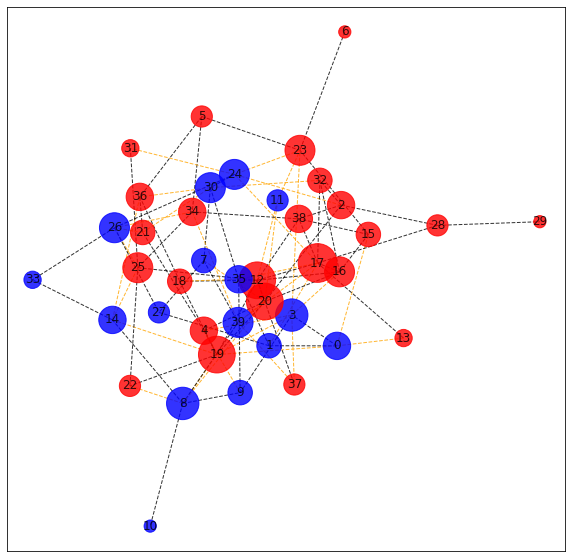

In [12]:
plt.figure(figsize=(10, 10))
G = make_network(nodes, edges)

#forme reason, the plotting tool comes with networkx can only take in lists 
#also, it has a very different sizing scale than Bokeh
#so I had to multiply the size by 30 for each node to appear more than just a tiny dot 
size = nx.get_node_attributes(G, 'size')
opinion = nx.get_node_attributes(G, "opinion")
nx.draw_networkx(G,
                node_color = ['red' if opinion[i] == 0 else 'blue' for i in G.nodes()],
                node_size = [30*size[i] for i in G.nodes()],
                alpha = 0.8,
                edge_color = list(nx.get_edge_attributes(G, 'edge_color').values()),
                style = 'dashed'
                )
plt.show()

## Plotting with Bokeh

Next we are going to create a plotting function using Bokeh. We choose Bokeh over the default NetworkX plotting tool because Bokeh comes with more interactive tools. 

The `make_plot` function will plot the network at a given time point t. If the selected model is discrete, the output will include a line plot of the opinion history up till time t on the right hand side; if the selected model is continuous, the output will include a histogram of the opinion distribution at time t. The combined output comes with boxzoom, select, and reset tool by default; in addition, we include a hover tool that displays the index, opinion, and degree of the node when the user hovers over that node. 

The function will also save the layout as a global variable if this is the first plot ever created. This is to make sure that all the plots that come after it will keep the same layout. 

In [13]:
from bokeh.io import output_file, show, output_notebook
from bokeh.models import (BoxSelectTool, BoxZoomTool, ResetTool, Circle, EdgesAndLinkedNodes, HoverTool,
                          MultiLine, NodesAndLinkedEdges, Plot, Range1d, TapTool,)
from bokeh.plotting import from_networkx
from bokeh.models import StaticLayoutProvider
from bokeh.transform import linear_cmap
from bokeh.plotting import figure, show
from bokeh.layouts import row

#define a make plot function 
def make_plot(G, layout, t, history1 = [], history0 = [], bins_number = 8, continuous = False):
    '''
    Arguments:
        G = a network object
        layout = the layout that the network plot follows 
        t = the current time, will be displayed in the plot title
        history1 = a list of historical percentages of opinion 1, only needed if the opinions are discrete
        history0 = a list of historical percentages of opinion 0, only needed if the opinions are discrete 
        bins_number = the number of bins for the histogram, only needed if the opinions are continuous
        continuous = whether the opinions are continuous 
    Returns:
        The combined plot of 1) the network plot and 2) a histogram if the opinions are continuous and a line plot otherwise.
    
    '''
    fig1 = figure(plot_width=480, plot_height=480,
              x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1),
              title = f'Network Plot at t = {t}')

    #add additional tools
    node_hover_tool = HoverTool(tooltips=[("index", "@index"), ("opinion", "@opinion"), ("degree", "@degree")])
    fig1.add_tools(node_hover_tool)

    #construct graph_renderer
    graph_renderer = from_networkx(G, layout, scale=1, center=(0, 0))

    #let the node color reflect the opinion and edge color reflect the discordancy between neighbors  
    graph_renderer.node_renderer.glyph = Circle(size="size", fill_color=linear_cmap('opinion', 'Blues8', nodes['opinion'].min(), nodes['opinion'].max()))
    graph_renderer.edge_renderer.glyph = MultiLine(line_color = "edge_color", line_dash = "dashed", line_alpha=0.8, line_width=1)

    #change hovered nodes' colors
    graph_renderer.node_renderer.hover_glyph = Circle(fill_color="orange")

    #append graph_renderer to figure 1
    fig1.renderers.append(graph_renderer)

    if continuous == False: #if the model is discrete, add a line plot on the right hand side 
        fig2 = figure(plot_width=480, plot_height=480, #initialize the line plot 
                      title = 'Change in % of Opinions Over Time',
                      x_axis_label='Epochs', y_axis_label='Percentage(from 0 to 1)',
                      x_range = [-0.1, epochs+0.1],
                     y_range = [-0.1,1.1])  
        
        opinions = list(nx.get_node_attributes(G, 'opinion').values())
        pct1 = sum(opinions)/len(opinions) #get % of opinion 1 holders
        pct0 = 1 - pct1 #get % of opinion 0 holders 
        history1.append(pct1) #append the % to the history 
        history0.append(pct0)
        fig2.line(x = np.arange(0,t+1), y = history1[:t+1], line_color = 'orange', legend_label="% of Opinion 1")
        fig2.line(x = np.arange(0,t+1), y = history0[:t+1], line_color = 'green', legend_label="% of Opinion 0")
    
    else: #if the model is continuous, add a histogram on the right hand side 
        d = nx.get_node_attributes(G, 'opinion') #extract the opinions 
        opinions = list(d.values())
        hist, edges = np.histogram(opinions, range = (0,1), density = False, bins=bins_number) 

        #append the histogram to figure 2
        fig2 = figure(plot_width=480, plot_height=480,
                      title = 'Distribution of opinions')
        fig2.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], line_color="white")
        
    #if it's the very first plot, we'll update the global variable fixed_layout 
    #this is so that all the plots after this will have the same layout 
    if layout == nx.spring_layout: 
        global fixed_layout
        fixed_layout = graph_renderer.layout_provider.graph_layout
        
    return row(fig1, fig2) #return combined plot 

## Implementing Update Methods

In [42]:
import random

def update(G, model, history1, history0, epochs = 5, threshold = 0.6, synchronous = False, m = 0.5, c = 0.5, p = 0.4, rewire_to_same = False):
    '''
    Arguments:
        G = a network object 
        model = the updating method, takes value in threshold, voter, or bounded-confidence
        history1 = a list of historical percentages of opinion 1, only needed if the opinions are discrete
        history0 = a list of historical percentages of opinion 0, only needed if the opinions are discrete 
        epochs = number of updates 
        threshold = the threshold above which the node will change its opinion, only needed for threshold model
        synchronous = whether the update is synchronous, only needed for threshold model
        m = the update rate or how much the nodes compromise, only needed for bounded-confidence model
        c = the compromise threshold below which the two neighboring nodes will compromise, only needed for bounded-confidence model
        p = the rewire rate below which the starting node of a chosen edge will rewire, only needed for voters model
        rewire_to_same = whether the node will only rewire to nodes holding the same opinion, only needed for voters model
    Returns:
        A list of plots from time 0 to the specified number of epochs. 
    '''
    plot_list = []
    plot_0 = make_plot(G, fixed_layout, 0, history1, history0)
    plot_list.append(plot_0)
  
    if model == "threshold":
        if(synchronous == False):
            #asynchronous update
            for i in range(1, epochs+1): #for each update
                for n, _ in G.nodes(data=True): #for each node
                    #check how many of its neighbors has similar/same opinions
                    ngbrs = [k for k in G.neighbors(n)]
                    num_ngbrs = len(ngbrs) #number of neighbors
                    num_same_opinion = 0
                    node_opinion = G.nodes[n]['opinion']
                    for ngbr in ngbrs: 
                        if G.nodes[ngbr]['opinion'] == node_opinion:
                            num_same_opinion += 1  #calculating the number of neighbors with the same opinion
                    num_diff_opinion = num_ngbrs - num_same_opinion #number of neighbors with different opinion
                    diff_ratio = num_diff_opinion/num_ngbrs
                    if diff_ratio > threshold:
                        #change node n's opinion to the opposite side
                        G.nodes[n]['opinion'] = 0 if node_opinion == 1 else 1  
                set_color_attrs(G)
                plot_i = make_plot(G, fixed_layout, i, history1, history0) #creates a plot for this round of update
                plot_list.append(plot_i)
        else:
            #synchronous update
            for i in range(1, epochs+1):
                node_opinions_origin = []
                for n, _ in G.nodes(data=True):
                    node_opinions_origin.append(G.nodes[n]['opinion'])
                #for each node, check how many of its neighbors has similar/same opinions
                for n, _ in G.nodes(data=True):
                    ngbrs = [k for k in G.neighbors(n)]
                    num_ngbrs = len(ngbrs)
                    num_same_opinion = 0
                    node_opinion = node_opinions_origin[n]
                    for ngbr in ngbrs: 
                        if node_opinions_origin[ngbr] == node_opinion:
                            num_same_opinion += 1  
                    num_diff_opinion = num_ngbrs - num_same_opinion
                    diff_ratio = num_diff_opinion/num_ngbrs
                    if diff_ratio > threshold:
                        #change node n's opinion to the opposite side
                        G.nodes[n]['opinion'] = 0 if node_opinion == 1 else 1  
                set_color_attrs(G)
                plot_s_i = make_plot(G,fixed_layout, i, history1, history0)
                plot_list.append(plot_s_i)
    
    elif model == "voter":
        for i in range(1, epochs+1): #for each update
            edges_ = list(G.edges) #pick a random edge 
            start_ind, end_ind = random.choice(edges_)
            #if the two nodes are discordant, compare a random probablity r to p 
            if (G.nodes[start_ind]['opinion'] != G.nodes[end_ind]['opinion']): 
                r = np.random.uniform(low=0.0, high=1.0)
                if r < p: #if r is smaller than p, then we rewire the starting node 
                    ngbrs = [k for k in G.neighbors(start_ind)] 
                    
                    #rewire to a random non-neighboring node if rewire_to_same == False
                    non_ngbrs = [x for x in list(G.nodes()) if x not in ngbrs] 
                    if rewire_to_same == True: #else only rewire to nodes that share the same opinion 
                        non_ngbrs = [x for x in non_ngbrs if G.nodes[x]['opinion'] == G.nodes[start_ind]['opinion']]
                    non_ngbr = random.choice(non_ngbrs)
                    
                    #rewire the starting node to non_ngbr
                    G.remove_edge(start_ind, end_ind) 
                    G.add_edge(start_ind, non_ngbr)
                else:
                    # the node opinion is updated
                    G.nodes[start_ind]['opinion'] = G.nodes[end_ind]['opinion']                      
            set_color_attrs(G)
            plot_v_i = make_plot(G, fixed_layout, i, history1, history0)
            plot_list.append(plot_v_i) #creates a plot for this round of update

    elif model == "bounded-confidence":
        for i in range(1, epochs+1):
            edges_ = list(G.edges)
            start_ind, end_ind = random.choice(edges_) #select a random edge 
            delta = G.nodes[end_ind]['opinion'] - G.nodes[start_ind]['opinion'] #find the difference between the two nodes' opinion 
            if np.absolute(delta) <= c: #update the opinion iff the difference is less than the compromise threshold 
                G.nodes[start_ind]['opinion'] += m*delta 
                G.nodes[end_ind]['opinion'] -= m*delta
            plot_bc_i = make_plot(G, fixed_layout, i, bins_number = 8, continuous = True) #make the plot at current time point and append it to the plot list 
            plot_list.append(plot_bc_i)
            
    return plot_list

## Adding Widgets

In this section, we combine our previously defined updating methods with customizable input options using Ipywidgets. Our end product consists of two main parts: 
1. An uploading interface where user can supply the data 
2. A visualization interface where user can customize the parameters and see the visualization 

### The Uploading Interface 

Now let's upload our own nodes and edges using upload widgets. 

The files uploaded must be of *csv* format. 

For the *nodes* dataframe, make sure that it has the following 2 columns with the same names and datatypes.
- ind: distinct index for each node, dtype = integer
- opinion:
  - Either 0 or 1 for a discrete model (threshold, voter), dtype = integer
  - Or a number between 0 and 1 for a continuous model (bounded-confidence), dtype = float

The ind column labels each node with an index and the opinion column has the corresponding opinion of the node at that index.

In [14]:
import io
import ipywidgets as widgets

# upload nodes dataframe
nodes_upload = widgets.FileUpload(
    accept='.csv',  
    multiple=False  
)

nodes_upload

FileUpload(value={}, accept='.csv', description='Upload')

If you get an error after running the code cell below, please run the code cell above again to upload the correctly formatted dataframe, and then run the cell below again to make sure everything is correct.

In [16]:
if(len(nodes_upload.value)) == 1:
    nodes = list(nodes_upload.value.values())[0]
    content = nodes['content']
    content = io.StringIO(content.decode('utf-8'))
    nodes = pd.read_csv(content)
    assert 'ind' and 'opinion' in nodes.columns, 'Columns are not named correctly'
    assert nodes['ind'].dtype == 'int64', 'ind column does not have dtype = int'
    assert nodes['opinion'].dtype == 'int64' or nodes['opinion'].dtype == 'float', 'opinion column does not have numeric dtype'

In [15]:
nodes.head()

,ind,opinion
0,0,1
1,1,1
2,2,0
3,3,1
4,4,0


For the *edges* dataframe, each row represents an edge. Make sure that it has the following 2 columns with the same names and datatypes.

- start: the starting node's index for the edge, dtype = integer
- end: the ending node's index for the edge, dtype = integer

For example, if our network has an edge (2,1) then we should have a row for which the column start = 2 and end = 1.

In [17]:
#upload edges dataframe
edges_upload = widgets.FileUpload(
    accept='.csv',  
    multiple=False  
)

edges_upload

FileUpload(value={}, accept='.csv', description='Upload')

If you get an error after running the code cell below, please run the code cell above again to upload the correctly formatted dataframe, and then run the cell below again to make sure everything is correct.

In [18]:
if(len(edges_upload.value)) == 1:
    edges = list(edges_upload.value.values())[0]
    content = edges['content']
    content = io.StringIO(content.decode('utf-8'))
    edges = pd.read_csv(content)
    assert 'start' and 'end' in edges.columns, 'Columns are not named correctly'
    assert edges['start'].dtype == 'int64', 'start column does not have dtype = int'
    assert edges['end'].dtype == 'int64', 'end column does not have dtype = int'
    edges['tup'] = list(zip(edges.start, edges.end))

In [19]:
edges.head()

,start,end,tup
0,19,8,"(19, 8)"
1,38,2,"(38, 2)"
2,12,16,"(12, 16)"
3,24,2,"(24, 2)"
4,15,16,"(15, 16)"


In [20]:
# Check if the user uploads both files
use_own_model = False
if(len(edges_upload.value) == 1 and len(nodes_upload.value) == 1):
    use_own_model = True

In [22]:
use_own_model

True

### The Visualization Interface

After the user supplies us with a correctly formatted dataset, the following cells can be run and a visualization interface will be displayed. 

The user will first be prompted to choose whether the opinions are continuous in the given datasets. If true, only the Bounded-Confidence method can be used. If the user chooses the wrong option in this step, the visualization will still display but cannot show meaningful results. 
- As for our sample data, use `nodes` to experiment with discrete update methods (Threshold and Voter) and `nodes2` to experiment with continuous update method (Bounded_Confidence).

If the user chooses False in the previous step, i.e. the opinions are not continuous, he/she can then choose the update method from the dropdown menu. Parameters that are specific to a particular update method will only be displayed when this method is chosen. For instance, the slider for adjusting the threshold will only show up if the user chooses the Threshold Method. 

After specifying the parameters, the user can drag the time slider to view the network at various time stamps. Sometimes there would be a small lag.

- WARNING: the plots will only be updated after the user drag the time slider. If the user changed other parameters without dragging the slider, the update will NOT be reflected on the plot. 


The output will include (i) a plot of the selected model at some specific timepoint on the left and (ii) a line plot (discrete) or a histogram (continuous) on the right. To visualize another network, rerun the sells above to upload a new set of data. 

In [26]:
# Setting epochs
epochs = 200

# Make a network using the user input data 
G_origin = make_network(nodes, edges)
G = G_origin.copy()

In [43]:
# Import Ipython and ipywidgets
from IPython.display import display
import ipywidgets as widgets

# Set default values

# Threshold model parameters
thres_val = 0.5 # Threshold using in the model
sync_val = False # Synchronous update 
d_thres = {} # Dictionary for threshold model plots
fixed_layout = nx.spring_layout # initialize fixed_layout as spring_layout 

# Bounded-confidence model parameters
c_val = 0.5 # c value in the model
m_val = 0.5 # m value in the model
d_bc = {} # Dictionary for bounded-confidence model plots

# Voter model parameters
p_val = 0.4 # probability below which the node will rewire 
rts_val = False # rewire_to_same value 
d_v = {} # Dictionary for voter model plots

# Define interactive functions
def display_timestamps_threshold(t):
    # Create a unique identifier for the combination of sync_val and thres_val
    id_thres = thres_val + 2 if sync_val == True else thres_val
    # If the plots given thres_val and sync_val are not stored, calculate; otherwise load
    if(id_thres not in d_thres):
        d_thres[id_thres]= update(G_origin.copy(), "threshold", [], [], epochs, threshold = thres_val, synchronous = sync_val)
    # Display the plot
    plot = d_thres[id_thres][t]
    show(plot)

def display_timestamps_bounded_confidence(t):
    # Create a unique identifier for the combination of c_val and m_val
    id_bc = str(c_val) + str(m_val) 
    # If the plots given c_val and m_val are not stored, calculate; otherwise load
    if(id_bc not in d_bc):
        d_bc[id_bc]= update(G_origin.copy(), "bounded-confidence", [], [], epochs, c = c_val, m = m_val)
    # Display the plot
    plot = d_bc[id_bc][t]
    show(plot)

def display_timestamps_voter(t):
    # Create a unique identifier for the p_val
    id_v = p_val +2 if rts_val == True else p_val
    # If the plots given p are not stored, calculate; otherwise load
    if(id_v not in d_v):
        d_v[id_v]= update(G_origin.copy(), "voter", [], [], epochs, p = p_val)
    # Display the plot
    plot = d_v[id_v][t]
    show(plot)

# Update thres_val
def change_thres(thres):
    global thres_val 
    thres_val = thres
    
# Update sync_val    
def change_sync(s):
    global sync_val
    sync_val = s
    
# Update c_val    
def change_c(c):
    global c_val
    c_val = c
    
# Update m_val          
def change_m(m):
    global m_val
    m_val = m
    
# Update p_val          
def change_p(p):
    global p_val
    p_val = p

#  Update rewire_to_same_val
def change_rewire(r):
    global rts_val
    rts_val = r

# Update whether the opinions are continuous
def display_cont(continuous):
    if continuous == 1: #if true only bounded-confidence method can be used 
        widgets.interact(change_c, c=c_slider)
        widgets.interact(change_m, m=m_slider)
        widgets.interact(display_timestamps_bounded_confidence, t=time_slider_bounded_confidence)
    elif continuous == 0: #else the user will be prompted to choose threshold or voter 
        widgets.interact(display_dropdown, model = model_dropdown) 
        

# Display a given set of sliders depending on the user's selection of updating method
def display_dropdown(model):
    # If the user chooses threshold model
    if model == 0:
        widgets.interact(change_thres, thres=threshold_slider)
        widgets.interact(change_sync, s=sync_checkbox)
        widgets.interact(display_timestamps_threshold, t=time_slider_threshold)
    # If the user chooses voter's model
    elif model == 1:
        widgets.interact(change_p, p=p_slider)
        widgets.interact(change_rewire, r=rewire_checkbox)
        widgets.interact(display_timestamps_voter, t=time_slider_voter)
    else: 
        print("Select Model")

# Define all the widgets 

# Dropdown menu for updating methods
cont_dropdown = widgets.Dropdown(
    options=[('Select', -1), ('True', 1), ('False', 0)],
    value=-1,
    description='Continuity',
    disabled=False,
)

# Dropdown menu for updating methods
model_dropdown = widgets.Dropdown(
    options=[('Choose Model', -1), ('Threshold', 0), ('Voters', 1)],
    value=-1,
    description='Model:',
    disabled=False,
)


# time_slider for threshold model
time_slider_threshold = widgets.IntSlider(
    value=0,
    min=0,
    max=epochs,
    step=1,
    description='Time:',
    disabled=False,
    continuous_update=False, #to reduce wait time
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

# threshold_slider
threshold_slider = widgets.FloatSlider(
    value=0.5,
    min=0,
    max=1,
    step=0.1,
    description='Threshold:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f'
)

# sync_checkbox
sync_checkbox = widgets.Checkbox(
    value=False,
    description='Synchronous',
    indent=True
)

# time_slider for bounded-confidence model
time_slider_bounded_confidence = widgets.IntSlider(
    value=0,
    min=0,
    max=epochs,
    step=1,
    description='Time:',
    disabled=False,
    continuous_update=False, #to reduce wait time
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

# c_slider
c_slider = widgets.FloatSlider(
    value=0.5,
    min=0,
    max=1,
    step=0.1,
    description='Comp rate',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f'
)

# m_slider
m_slider = widgets.FloatSlider(
    value=0.5,
    min=0,
    max=1,
    step=0.1,
    description='Update rate:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f'
)

# p_slider
p_slider = widgets.FloatSlider(
    value=0.5,
    min=0,
    max=1,
    step=0.1,
    description='Rewire rate:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f'
)

# rewire_to_same_checkbox
rewire_checkbox = widgets.Checkbox(
    value=False,
    description='Only rewire to the same nodes ',
    indent=True
)

# time_slider for voter model
time_slider_voter = widgets.IntSlider(
    value=0,
    min=0,
    max=epochs,
    step=1,
    description='Time:',
    disabled=False,
    continuous_update=False, #to reduce wait time
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

# Show the output
output_notebook()
print('Select if the opinions are continuous. If true, only Bounded-Confidence Model can be used.')
widgets.interact(display_cont, continuous=cont_dropdown)

Loading BokehJS ...

Select if the opinions are continuous. If true, only Bounded-Confidence Model can be used.


interactive(children=(Dropdown(description='Continuity', options=(('Select', -1), ('True', 1), ('False', 0)), …

<function __main__.display_cont(continuous)>